In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

def load_and_clean_data(filepath):
    print("Carregando dataset...")
    df = pd.read_csv(filepath, low_memory=False)

    print(f"Dimensões originais: {df.shape}")

    df['CANCELLATION_REASON'] = df['CANCELLATION_REASON'].fillna('None')

    delay_cols = [
        'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
        'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'
    ]
    df[delay_cols] = df[delay_cols].fillna(0)

    df_completed = df[(df['CANCELLED'] == 0) & (df['DIVERTED'] == 0)].copy()

    df_completed = df_completed.dropna(subset=['ARRIVAL_DELAY', 'DEPARTURE_DELAY'])

    print(f"Dimensões após limpeza (apenas voos concluídos): {df_completed.shape}")

    return df, df_completed

df_raw, df_clean = load_and_clean_data('../data/flights.csv')

Carregando dataset...
Dimensões originais: (5819079, 31)
Dimensões após limpeza (apenas voos concluídos): (5714008, 31)


--- Estatísticas Descritivas Básicas ---


,DEPARTURE_DELAY,ARRIVAL_DELAY,AIR_TIME,DISTANCE
count,5.714008e+06,5.714008e+06,5.714008e+06,5.714008e+06
mean,9.294842e+00,4.407057e+00,1.135116e+02,8.244569e+02
std,3.688972e+01,3.927130e+01,7.223082e+01,6.086620e+02
min,-8.200000e+01,-8.700000e+01,7.000000e+00,3.100000e+01
25%,-5.000000e+00,-1.300000e+01,6.000000e+01,3.730000e+02
50%,-2.000000e+00,-5.000000e+00,9.400000e+01,6.500000e+02
75%,7.000000e+00,8.000000e+00,1.440000e+02,1.065000e+03
max,1.988000e+03,1.971000e+03,6.900000e+02,4.983000e+03


/tmp/ipykernel_95477/2436648653.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




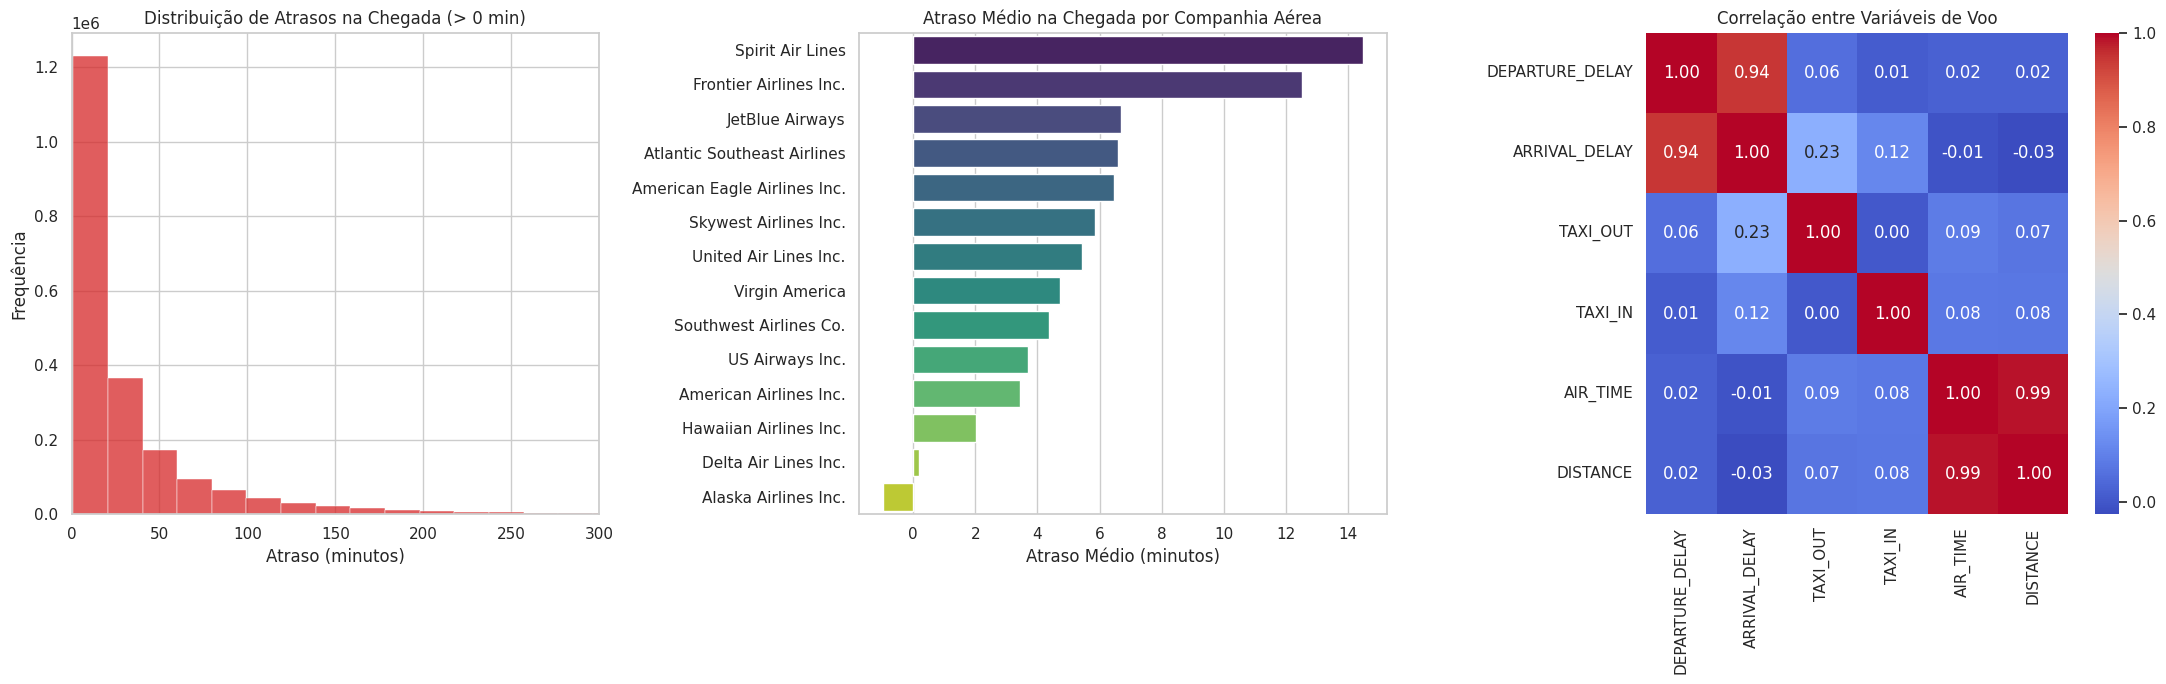

In [11]:
airlines_df = pd.read_csv('../data/airlines.csv')

df_clean = df_clean.merge(airlines_df, left_on='AIRLINE', right_on='IATA_CODE', how='left')

df_clean.rename(columns={'AIRLINE_y': 'AIRLINE_NAME', 'AIRLINE_x': 'AIRLINE'}, inplace=True)
if 'IATA_CODE' in df_clean.columns:
    df_clean.drop('IATA_CODE', axis=1, inplace=True)

print("--- Estatísticas Descritivas Básicas ---")
display(df_clean[['DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'AIR_TIME', 'DISTANCE']].describe())

fig, axes = plt.subplots(1, 3, figsize=(22, 7))

# Gráfico A: Distribuição de Atrasos (> 0 min)
sns.histplot(df_clean[df_clean['ARRIVAL_DELAY'] > 0]['ARRIVAL_DELAY'],
             bins=100, color='#d62728', ax=axes[0])
axes[0].set_title('Distribuição de Atrasos na Chegada (> 0 min)')
axes[0].set_xlabel('Atraso (minutos)')
axes[0].set_ylabel('Frequência')
axes[0].set_xlim(0, 300)

# Gráfico B: Média de Atraso por Companhia Aérea
avg_delay_airline = df_clean.groupby('AIRLINE_NAME')['ARRIVAL_DELAY'].mean().sort_values(ascending=False)

sns.barplot(x=avg_delay_airline.values, y=avg_delay_airline.index, palette='viridis', ax=axes[1])
axes[1].set_title('Atraso Médio na Chegada por Companhia Aérea')
axes[1].set_xlabel('Atraso Médio (minutos)')
axes[1].set_ylabel('')

# Gráfico C: Matriz de Correlação
corr_cols = ['DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'TAXI_OUT', 'TAXI_IN', 'AIR_TIME', 'DISTANCE']
sns.heatmap(df_clean[corr_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f", ax=axes[2])
axes[2].set_title('Correlação entre Variáveis de Voo')

plt.tight_layout()
plt.show()

In [12]:
# 1. Criação da Variável Alvo (Target para Classificação
df_clean['IS_DELAYED'] = (df_clean['ARRIVAL_DELAY'] > 15).astype(int)

# 2. Engenharia de Recursos de Tempo
def categorize_time_of_day(time_hhmm):
    hour = time_hhmm // 100
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df_clean['TIME_OF_DAY'] = df_clean['SCHEDULED_DEPARTURE'].apply(categorize_time_of_day)

# 3. Engenharia de Recursos de Sazonalidade (Estações do Ano no Hemisfério Norte - EUA)
def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    else: return 'Autumn'

df_clean['SEASON'] = df_clean['MONTH'].apply(get_season)

# 4. Amostragem Estratégica para Machine Learning
df_ml = df_clean.sample(frac=0.05, random_state=42).copy()

print("Justificativa de Amostragem: A redução para 5% do dataset original preserva a distribuição das classes e viabiliza a execução de validação cruzada sem estouro de memória.")
print(f"Dimensões da base para modelagem: {df_ml.shape}")

Justificativa de Amostragem: A redução para 5% do dataset original preserva a distribuição das classes e viabiliza a execução de validação cruzada sem estouro de memória.
Dimensões da base para modelagem: (285700, 35)


Iniciando treinamento e validação cruzada...

--- Regressão Logística ---
CV ROC-AUC Médio: 0.6315 (+/- 0.0045)

Relatório no Teste Final (Holdout):
              precision    recall  f1-score   support

           0       0.88      0.58      0.70     46971
           1       0.24      0.62      0.35     10169

    accuracy                           0.59     57140
   macro avg       0.56      0.60      0.53     57140
weighted avg       0.76      0.59      0.64     57140

--- Random Forest ---
CV ROC-AUC Médio: 0.6395 (+/- 0.0026)

Relatório no Teste Final (Holdout):
              precision    recall  f1-score   support

           0       0.87      0.68      0.76     46971
           1       0.26      0.52      0.35     10169

    accuracy                           0.65     57140
   macro avg       0.57      0.60      0.56     57140
weighted avg       0.76      0.65      0.69     57140



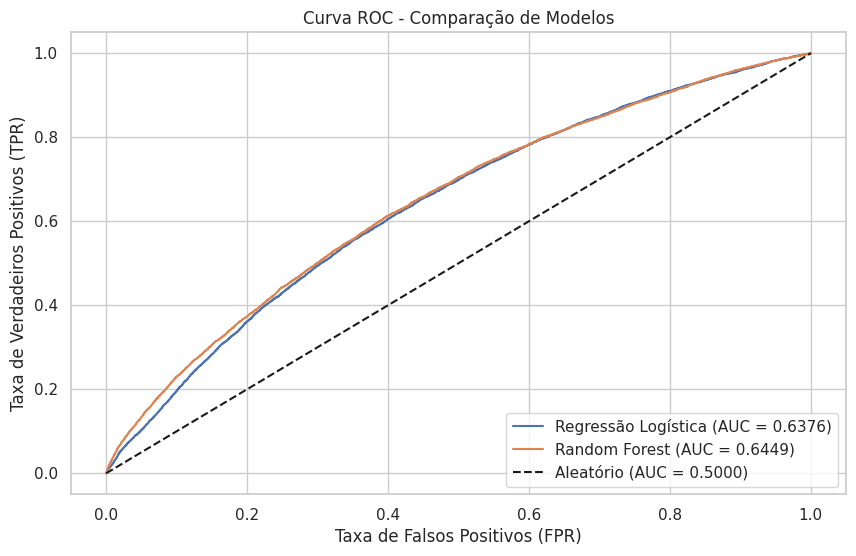


--- Extração de Feature Importance (Random Forest) ---


/tmp/ipykernel_95477/1379305456.py:97: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




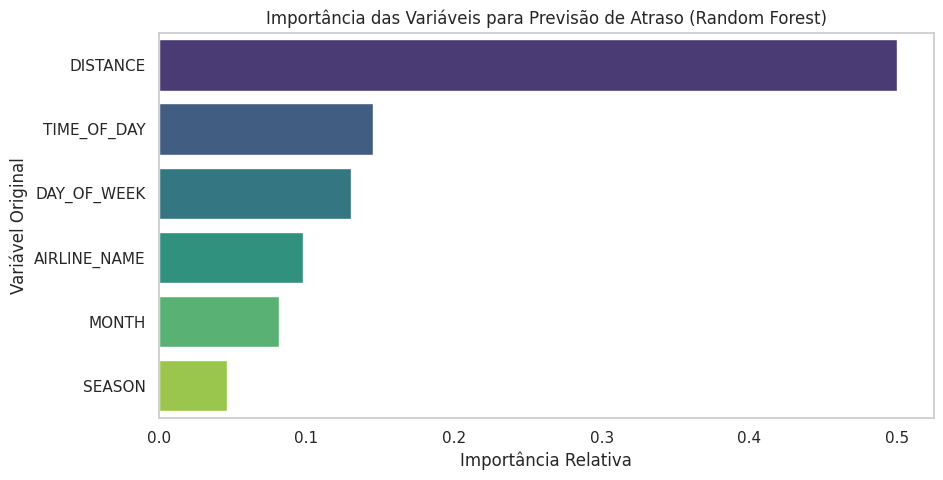

In [13]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Seleção de Features e Target
features = ['AIRLINE_NAME', 'DAY_OF_WEEK', 'MONTH', 'TIME_OF_DAY', 'SEASON', 'DISTANCE']
X = df_ml[features]
y = df_ml['IS_DELAYED']

# 2. Divisão Holdout para teste final (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Pipeline de Pré-processamento
cat_features = ['AIRLINE_NAME', 'TIME_OF_DAY', 'SEASON']
num_features = ['DAY_OF_WEEK', 'MONTH', 'DISTANCE']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])

# 4. Definição dos Modelos
models = {
    "Regressão Logística": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
}

# 5. Treinamento, Cross-Validation e Plotagem ROC
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

plt.figure(figsize=(10, 6))
print("Iniciando treinamento e validação cruzada...\n")

for name, model in models.items():
    print(f"--- {name} ---")
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])

    cv_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    print(f"CV ROC-AUC Médio: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]

    print("\nRelatório no Teste Final (Holdout):")
    print(classification_report(y_test, y_pred))

    # Extração de dados para Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.4f})")

    results[name] = clf

# Configurações do Gráfico ROC
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório (AUC = 0.5000)')
plt.title('Curva ROC - Comparação de Modelos')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 6. Feature Importance (Random Forest)
print("\n--- Extração de Feature Importance (Random Forest) ---")
rf_model = results["Random Forest"]

# Mapeamento de features originais vs codificadas
ohe_feature_names = rf_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(cat_features)
all_feature_names = num_features + list(ohe_feature_names)
importances = rf_model.named_steps['classifier'].feature_importances_

df_importances = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})

# Função para agrupar as colunas geradas pelo OneHotEncoder de volta à variável base
def get_base_feature(feat_name):
    for cat in cat_features:
        if feat_name.startswith(cat):
            return cat
    return feat_name

df_importances['Base_Feature'] = df_importances['Feature'].apply(get_base_feature)
grouped_importances = df_importances.groupby('Base_Feature')['Importance'].sum().sort_values(ascending=False)

# Gráfico de Feature Importance
plt.figure(figsize=(10, 5))
sns.barplot(x=grouped_importances.values, y=grouped_importances.index, palette='viridis')
plt.title('Importância das Variáveis para Previsão de Atraso (Random Forest)')
plt.xlabel('Importância Relativa')
plt.ylabel('Variável Original')
plt.grid(axis='x')
plt.show()

--- 1. Preparação e Normalização dos Dados ---

--- 2. Justificativa Matemática: Método do Cotovelo ---


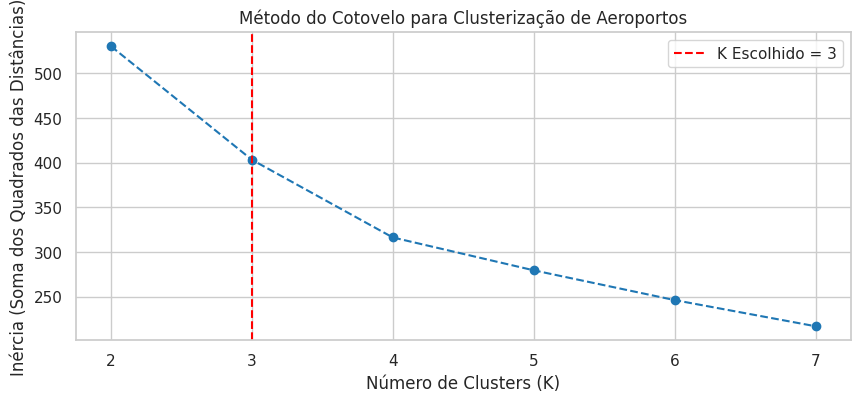

Justificativa: A redução da inércia torna-se marginal após K=3, confirmando 3 como o número ideal de perfis.

--- 3. Execução do K-Means e Visualização dos Grupos ---


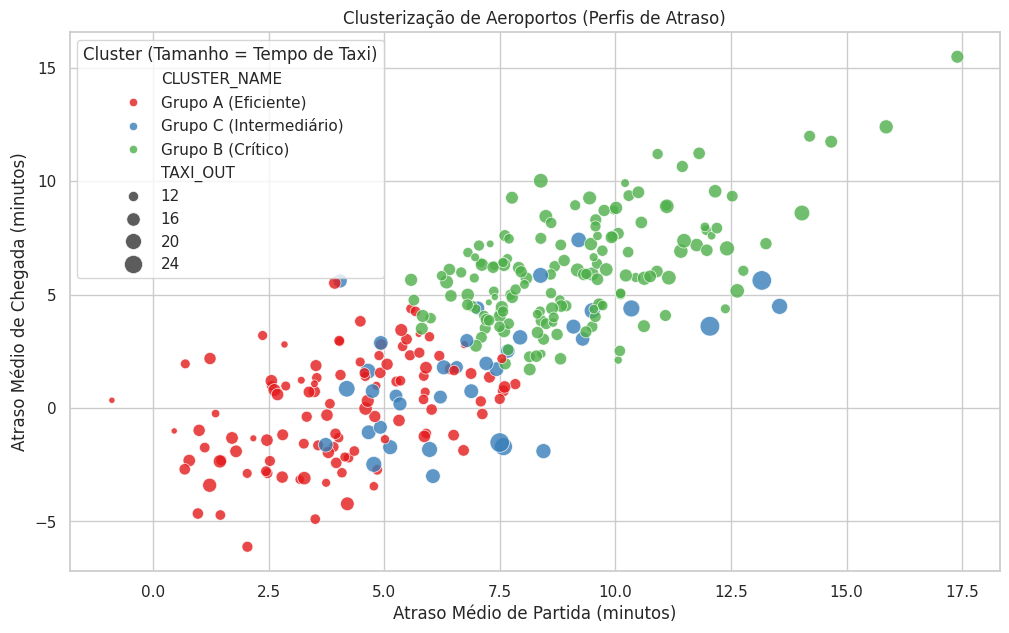

--- Perfil Médio de Cada Cluster ---


,DEPARTURE_DELAY,ARRIVAL_DELAY,TAXI_OUT
CLUSTER_NAME,,,
Grupo A (Eficiente),4.09,-0.02,12.88
Grupo B (Crítico),9.14,6.02,13.87
Grupo C (Intermediário),7.13,1.63,19.08


In [14]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

print("--- 1. Preparação e Normalização dos Dados ---")
# Agregando métricas médias por Aeroporto de Origem
airport_stats = df_clean.groupby('ORIGIN_AIRPORT').agg({
    'DEPARTURE_DELAY': 'mean',
    'ARRIVAL_DELAY': 'mean',
    'TAXI_OUT': 'mean',
    'FLIGHT_NUMBER': 'count'
}).rename(columns={'FLIGHT_NUMBER': 'TOTAL_FLIGHTS'})

# Filtrando aeroportos pequenos para evitar ruído
airport_stats = airport_stats[airport_stats['TOTAL_FLIGHTS'] > 1000].copy()

# Normalização
features_to_cluster = ['DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'TAXI_OUT']
scaler_kmeans = StandardScaler()
airport_scaled = scaler_kmeans.fit_transform(airport_stats[features_to_cluster])

print("\n--- 2. Justificativa Matemática: Método do Cotovelo ---")
inercia = []
k_range = range(2, 8)

for k in k_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(airport_scaled)
    inercia.append(kmeans_temp.inertia_)

plt.figure(figsize=(10, 4))
plt.plot(k_range, inercia, marker='o', linestyle='--', color='#1f77b4')
plt.title('Método do Cotovelo para Clusterização de Aeroportos')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inércia (Soma dos Quadrados das Distâncias)')
plt.axvline(x=3, color='red', linestyle='--', label='K Escolhido = 3')
plt.legend()
plt.grid(True)
plt.show()
print("Justificativa: A redução da inércia torna-se marginal após K=3, confirmando 3 como o número ideal de perfis.")

print("\n--- 3. Execução do K-Means e Visualização dos Grupos ---")
# Treinamento com o K escolhido
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
airport_stats['CLUSTER'] = kmeans.fit_predict(airport_scaled)

# Mapeamento
airport_stats['CLUSTER_NAME'] = airport_stats['CLUSTER'].map({
    0: 'Grupo A (Eficiente)', 1: 'Grupo B (Crítico)', 2: 'Grupo C (Intermediário)'
})

# Visualização final
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=airport_stats,
    x='DEPARTURE_DELAY',
    y='ARRIVAL_DELAY',
    hue='CLUSTER_NAME',
    size='TAXI_OUT',
    sizes=(20, 200),
    palette='Set1',
    alpha=0.8
)

plt.title('Clusterização de Aeroportos (Perfis de Atraso)')
plt.xlabel('Atraso Médio de Partida (minutos)')
plt.ylabel('Atraso Médio de Chegada (minutos)')
plt.legend(title='Cluster (Tamanho = Tempo de Taxi)')
plt.grid(True)
plt.show()

# Resumo
print("--- Perfil Médio de Cada Cluster ---")
display(airport_stats.groupby('CLUSTER_NAME')[features_to_cluster].mean().round(2))

In [15]:
import plotly.express as px

print("\n--- 2. Extra: Mapa Geográfico de Clusters de Aeroportos ---")
airports_geo = pd.read_csv('../data/airports.csv')

map_data = airport_stats.reset_index().merge(airports_geo, left_on='ORIGIN_AIRPORT', right_on='IATA_CODE')

map_data['MARKER_SIZE'] = map_data['DEPARTURE_DELAY'].clip(lower=1)

fig = px.scatter_geo(
    map_data,
    lat='LATITUDE',
    lon='LONGITUDE',
    color='CLUSTER_NAME',
    size='MARKER_SIZE',
    hover_name='AIRPORT',
    hover_data={'LATITUDE': False, 'LONGITUDE': False, 'MARKER_SIZE': False, 'DEPARTURE_DELAY': True, 'ARRIVAL_DELAY': True},
    scope='usa',
    title='Mapa de Aeroportos por Eficiência de Voo (Tamanho da bolha = Gravidade do Atraso)',
    color_discrete_map={'Grupo A': '#2ca02c', 'Grupo B': '#d62728', 'Grupo C': '#1f77b4'}
)

fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig.show()


--- 2. Extra: Mapa Geográfico de Clusters de Aeroportos ---
